Imports

In [38]:
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

#use seaborn for plotting defaults
import seaborn as sns; sns.set()

Data aquisition

In [39]:
def from_folder(folder_path):
    strokesets = []
    xml_paths = glob.glob(os.path.join(folder_path, "**/*.xml"), recursive=True)
    for xml_path in xml_paths:
        tree = ET.parse(xml_path)
        _strokesets = tree.find(".//StrokeSet")
        strokeSet = [np.array([(float(point.get("x")), float(point.get("y")), float(point.get("time")))
                               for point in stroke.findall("./Point")]) for stroke in _strokesets.findall("./Stroke")]
        strokesets.append(format_strokeset(strokeSet))
    return strokesets

def format_strokeset(strokeset):
    # compute bbox properties of strokeset
    pts = np.concatenate(strokeset, axis=0)  # extract the x,y coordinates
    pts = pts.reshape((-1, 3))[:, :2]
    x_min, y_min = np.min(pts, axis=0)
    x_max, y_max = np.max(pts, axis=0)
    w, h = x_max - x_min, y_max - y_min
    if w == 0 or h == 0:
        return None
    
    # transform the points in the strokeset so that the top-left of the bbox is their origin
    # starting time is set to 0 for that substract the first point time from all points time
    for stroke in strokeset:
        stroke -= [x_min, y_min, stroke[0, 2]]

    return strokeset

def display_strokeset(strokeset, scale_factor=0.1, title="Strokeset"):
    pts = np.concatenate(strokeset, axis=0)
    x_min, y_min = np.min(pts[:, :2], axis=0)
    x_max, y_max = np.max(pts[:, :2], axis=0)
    w, h = int(scale_factor * (x_max - x_min)), int(scale_factor * (y_max - y_min))
    if w == 0 or h == 0:
        return
    image = np.zeros((h, w), dtype=np.uint8)
    pts -= [x_min, y_min, 0]
    pts *= scale_factor
    pts = pts[:, :2]  # remove the z-dimension
    pts = pts.astype(np.int32)
    strokes = np.split(pts, np.cumsum([len(s) for s in strokeset[:-1]]))
    for stroke in strokes:
        cv2.polylines(image, [stroke], isClosed=False, color=255, thickness=2)
    cv2.imshow(title, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [40]:
strokesets = from_folder("original")

In [41]:
# count the number of stroke in all the 0, 1, 2, 3 stroksets strokes with length less than 300 and greaterthan 2
stroke_count = [len(strokeset) for strokeset in strokesets[:4] if strokeset is not None and len(strokeset) < 300 and len(strokeset) > 2]
sum(stroke_count)

783

Preprocessing

In [42]:
# convert strokesets to a list of strokes efficiently
strokes = []   
for strokeset in strokesets:
    strokes.extend(strokeset)
len(strokes)

from collections import Counter

lengths = [len(stroke) for stroke in strokes]
freq_list = dict(Counter(lengths + [0]))


# save the sorted dictionary to txt file
with open('strokes_length.txt', 'w') as f:
    for key in sorted(freq_list.keys()):
        f.write("%s %s\n"%(key, freq_list[key]))

#remove every stroke with length greater than 300 and less than 2
strokes = [stroke for stroke in strokes if len(stroke) <= 300 and len(stroke) > 2]



In [43]:
# replace every stroke with length less than 300 with a stroke of length 300
max_length = 300
strokes = np.array([np.concatenate([stroke, np.zeros((max_length - len(stroke), 3))]) for stroke in strokes])

In [44]:
# make each stroke have displacement data instead of absolute coordinates
def absolute_to_displacement(strokes):

    # get boolean values if the point is (0, 0, 0)
    mask = np.all(strokes[:, 1:] == 0, axis=2)

    # get the index of first True in each stroke
    first_nonzero = np.argmax(mask, axis=1)
    
    # Find the differences between consecutive points
    displacements = np.diff(strokes, axis=1)

    # replace the first non zero point with (0, 0, 0) using the first_nonzero index
    displacements[np.arange(len(displacements)), first_nonzero] = 0

    # add a point with (0, 0, 0) at the end to make the length of the stroke 300
    displacements = np.concatenate([displacements, np.zeros((len(displacements), 1, 3)).astype(np.int32)], axis=1)

    return displacements

strokes = absolute_to_displacement(strokes)


In [45]:
strokes.shape

(267141, 300, 3)

Auto-encoder for correcting anomalies

In [106]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch import optim
import time
import random
from pyemd import emd
import pysdtw

In [47]:
strokes = torch.from_numpy(strokes).float()

MAX_STROKE_LEN = 300

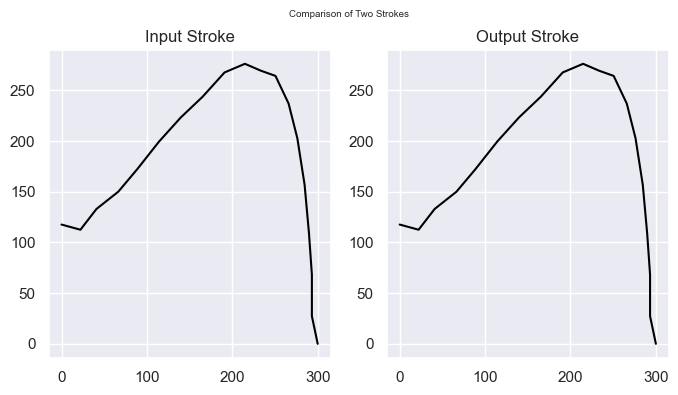

In [107]:
def display_strokes(stroke1, stroke2, title = "Comparison of Two Strokes"):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))

    def process_stroke(stroke):
        stroke = stroke.numpy()
        stroke = stroke[~(np.all(stroke == 0, axis=1))]

        # convert displacement to absolute coordinates
        stroke = np.cumsum(stroke, axis=0)

        x_min, y_min = np.min(stroke[:, :2], axis=0)
        x_max, y_max = np.max(stroke[:, :2], axis=0)
        scale_factor = 300 / max(x_max - x_min, y_max - y_min)
        stroke -= [x_min, y_min, stroke[0, 2]]
        stroke *= scale_factor
        stroke = stroke[:, :2]
        return stroke

    # Stroke 1
    stroke1 = process_stroke(stroke1)
    ax1.plot(stroke1[:, 0], stroke1[:, 1], color='black')
    ax1.set_title("Input Stroke")

    # Stroke 2
    stroke2 = process_stroke(stroke2)
    ax2.plot(stroke2[:, 0], stroke2[:, 1], color='black')
    ax2.set_title("Output Stroke")

    # Set plot title
    fig.suptitle(title, fontsize=7)

    plt.show()

display_strokes(strokes[723], strokes[723])

In [49]:
# Dataset

class StrokeDataset(Dataset):
    def __init__(self, strokes):
        self.strokes = strokes

    def __len__(self):
        return len(self.strokes)

    def __getitem__(self, index):
        stroke = self.strokes[index]
        return stroke, stroke

In [97]:
# Modifier layers

# LSTM() returns tuple of (tensor, (recurrent state))
class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        tensor, _ = x
        # Reshape shape (batch, hidden)
        return tensor[:, -1, :]
    
class NormalizeStrokes(nn.Module):
    def __init__(self):
        super(NormalizeStrokes, self).__init__()

    def forward(self, strokes):
        # Orient all the strokes to start from the origin
        strokes = strokes - strokes[:,0:1,:]

        # Rescale the strokes to have unit norm
        means = torch.mean(strokes, axis=(0, 1), keepdim=True)
        stds = torch.std(strokes, axis=(0, 1), keepdim=True)
        normalized_strokes = (strokes - means) / stds
        return normalized_strokes
    

In [118]:
# Losses


class MAELoss(nn.Module):
    def __init__(self):
        super(MAELoss, self).__init__()
        self.normalize = NormalizeStrokes()

    def forward(self, output, target):
        # Normalize the inputs
        target = self.normalize(target)
        
        # Compute the MSE loss
        mse_loss = DTWLoss()(output, target)
        return mse_loss


class EMDLoss(nn.Module):
    def __init__(self, x_weight=1.0, y_weight=1.0, t_weight=0.5):
        super(EMDLoss, self).__init__()
        self.x_weight = x_weight
        self.y_weight = y_weight
        self.t_weight = t_weight

    def forward(self, stroke1, stroke2):

        # Compute the Euclidean distances for each component
        x_dist = torch.abs(stroke1[:, :, 0].unsqueeze(2) - stroke2[:, :, 0].unsqueeze(1))
        y_dist = torch.abs(stroke1[:, :, 1].unsqueeze(2) - stroke2[:, :, 1].unsqueeze(1))
        t_dist = torch.abs(stroke1[:, :, 2].unsqueeze(2) - stroke2[:, :, 2].unsqueeze(1))

        # Compute the weights for each component
        x_weighted_dist = self.x_weight * x_dist
        y_weighted_dist = self.y_weight * y_dist
        t_weighted_dist = self.t_weight * t_dist

        # Compute the cost matrix for EMD
        cost_matrix = x_weighted_dist + y_weighted_dist + t_weighted_dist
        cost_matrix = cost_matrix.view(cost_matrix.size(0), -1, cost_matrix.size(2))

        # Compute the EMD
        emd = torch.ops.transport(
            cost_matrix=cost_matrix, 
            eps=0.05, 
            max_iter=10000, 
            verbose=False
        )

        return emd


class DTWLoss(nn.Module):
    def __init__(self):
        super(DTWLoss, self).__init__()
        self.normalize = NormalizeStrokes()
        self.sdtw = pysdtw.SoftDTW(gamma=1.0, dist_func='sqeuclidean', use_cuda=False)

    def forward(self, x, y):
        y = self.normalize(y)

        # calculate the Soft-DTW distance
        dist = self.sdtw(x, y)
        # return the mean distance over the batch
        return dist.mean()



In [119]:
# Autoencoder

class StrokeAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(StrokeAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # Encoder layers
        self.encoder = nn.Sequential(
            NormalizeStrokes(),
            nn.LSTM(input_dim, hidden_dim, batch_first=True),
            extract_tensor(),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.LSTM(latent_dim, hidden_dim, batch_first=True),
            extract_tensor(),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim * MAX_STROKE_LEN),
        )

    def forward(self, x):
        # Encode the input sequence
        latent = self.encoder(x)

        # Reshape the hidden state for the decoder
        z = latent.view(-1, 1, self.latent_dim)

        # Decode the encoded sequence
        x_hat = self.decoder(z)
        x_hat = x_hat.view(-1, MAX_STROKE_LEN, self.input_dim)

        return x_hat


In [120]:
# Model and dataset properties

model = StrokeAutoencoder(input_dim=3, hidden_dim=128, latent_dim=64)

dataset = StrokeDataset(strokes)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create a dataset that contains a subset of the data
disp_indices = list(range(700, 797))
disp_dataset = torch.utils.data.Subset(dataset, disp_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

criterion = DTWLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [121]:
# Training loop

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    # Training loop
    for i, batch in enumerate(train_loader):

        #start timer
        start = time.time()

        optimizer.zero_grad()
        input_seq, target_seq = batch
        output_seq = model(input_seq)
        loss = criterion(output_seq, target_seq)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()


        print_every = 10
        if (i+1) % print_every == 0:
            
            # Select a random element from the dataset
            random_element = random.choice(disp_dataset)

            input_seq, target_seq = random_element
            input_seq = input_seq.unsqueeze(0)

            # Generate the output sequence using the model
            output_seq = model(input_seq)

            # print time elapsed after evry batch in format
            end = time.time()
            print(f"Batch {i+1}/{len(train_loader)}: {end - start:.4f} seconds\t Loss: {loss.item():.4f}")

            # Display the input and output strokes for the first sequence in the batch
            display_strokes(input_seq[0], output_seq[0].detach(), title=f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}: train_loss={train_loss/print_every:.4f}")
            train_loss = 0.0

    # Validation loop
    with torch.no_grad():
        val_loss = 0.0
        for batch in val_loader:
            input_seq, target_seq = batch
            output_seq = model(input_seq)
            val_loss += criterion(output_seq, target_seq).item() * input_seq.size(0)
        val_loss /= len(val_dataset)

    # Print the training and validation losses for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss/len(train_loader):.4f} val_loss={val_loss:.4f}")

TypeError: 'str' object is not callable